# 5.9  CNN-LSTM architectures

In [ ]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

This type of architecture is useful for different applications, for instance, action recognition in video sequences. In order to show its use, we are going to create a syntethic dataset. 

The dataset is composed of videos where a point moves through the frames forming four different patterns: a constant point, a point ascending from bottom-left corner to top-right corner, a point descending from top-lef corner to bottom-right corner, and a point following a sin function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from keras.utils import np_utils
from tensorflow.keras.layers import LSTM, Conv2D, Dense, TimeDistributed, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

Using TensorFlow backend.


In [2]:
import tensorflow as tf
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
%matplotlib notebook

In [4]:
import math
t = np.linspace(math.pi/10, 2*math.pi, num=20)
y = np.sin(t) + 0.05*np.random.randn(1, 20)
y = y.flatten()
i = 1
t2 = 6*i
y2 = int(np.round(23*(y[i-1]+1)+4))

In [5]:
def f(t2, y2):
    m = np.zeros((50,130))
    m[y2-3:y2+3,t2-3:t2+3] = 255
    return m

def updatefig(*args):
    global y,i
    if i == 20:
        i = 1
    t2 = 6*i
    y2 = int(np.round(23*(y[i-1]+1)+4))
    i += 1
    im.set_array(f(t2,y2))
    return im,

def updatefig2(*args):
    global y,i
    if i == 20:
        i = 1
    t2 = 6*(i+1)
    y2 = int(np.round(2*(i+1) + 2 + np.random.randn(1)))
    i += 1
    im.set_array(f(t2,y2))
    return im,

<IPython.core.display.Javascript object>


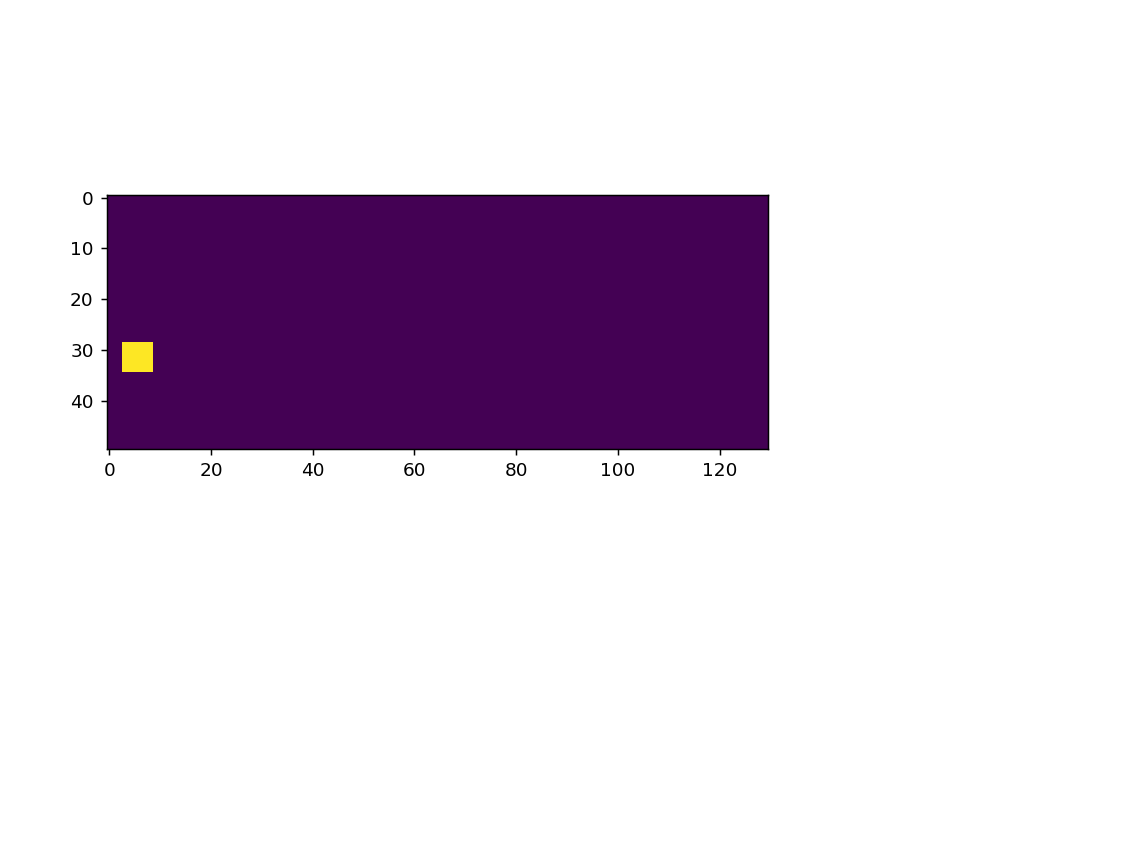

In [6]:
fig = plt.figure()
im = plt.imshow(f(t2, y2))
ani = animation.FuncAnimation(fig, updatefig, interval=50, frames=20, blit=True)

This is an example of a sin pattern.

In [7]:
from IPython.display import HTML
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>


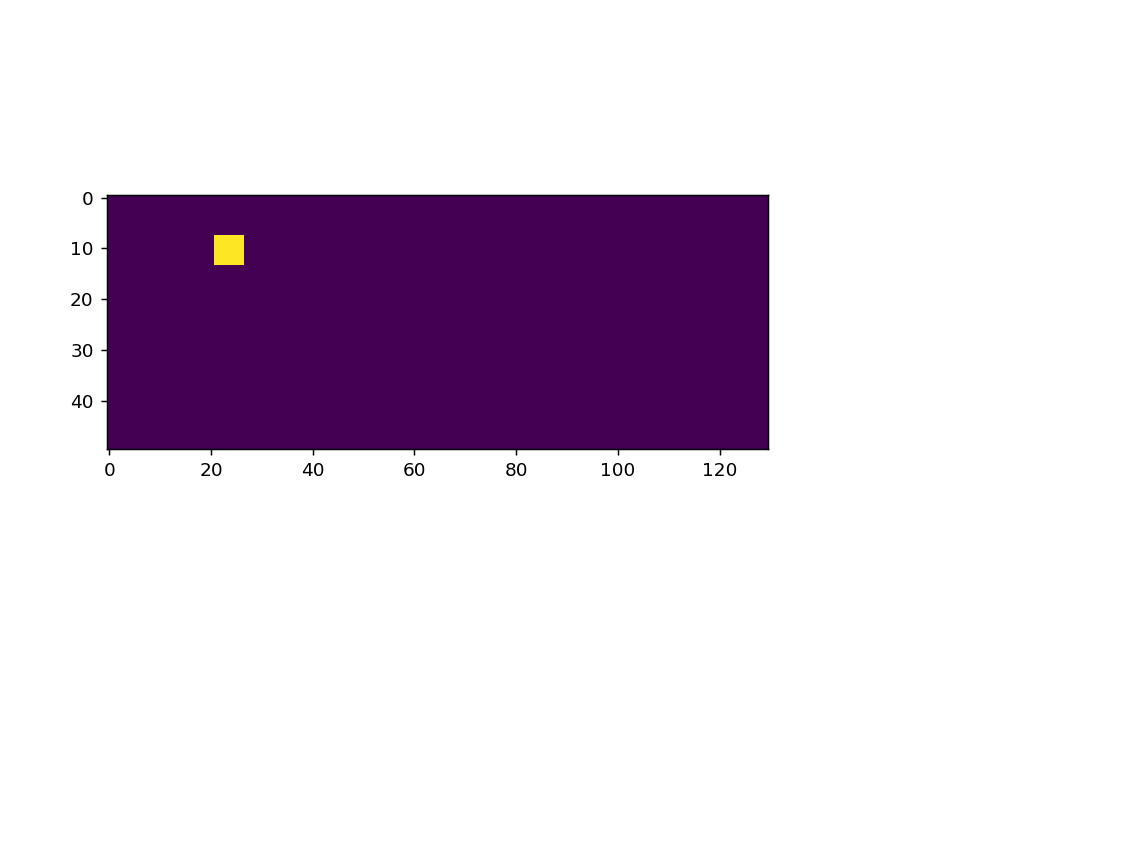

In [8]:
i=1
t2 = 6*(i+1)
y2 = int(np.round(2*(i+1) + 2 + np.random.randn(1)))


fig = plt.figure()
im = plt.imshow(f(t2, y2))
ani = animation.FuncAnimation(fig, updatefig2, interval=50, frames=20, blit=True)

from IPython.display import HTML
HTML(ani.to_jshtml())

The data must have the form **[n_samples,n_times,n_rows,n_columns,n_channels]**

In [38]:
#Class sin
Videos1 = np.zeros((20,20,50,130,1))
for j in range(20):
    y = np.sin(t) + 0.05*np.random.randn(1, 20)
    y = y.flatten()
    for i in range(20):
        t2 = 6*(i+1)
        y2 = int(np.round(23*(y[i]+1)+4))
        Videos1[j,i,:,:,0] = f(t2,y2)/255
#Class constan
Videos2 = np.zeros((20,20,50,130,1))
for j in range(20):
    for i in range(20):
        t2 = int(np.round(25 + np.random.randn(1)))
        y2 = int(np.round(65 + np.random.randn(1)))
        Videos2[j,i,:,:,0] = f(t2,y2)/255
#Class ascending
Videos3 = np.zeros((20,20,50,130,1))
for j in range(20):
    for i in range(20):
        t2 = 6*(i+1)
        y2 = int(np.round(2*(i+1) + 2 + np.random.randn(1)))
        Videos3[j,i,:,:,0] = f(t2,y2)/255
#Class descending
Videos4 = np.zeros((20,20,50,130,1))
for j in range(20):
    for i in range(20):
        t2 = 6*(i+1)
        y2 = int(np.round(2*(20-i)+ 2 + np.random.randn(1)))
        Videos4[j,i,:,:,0] = f(t2,y2)/255
Videos = np.concatenate((Videos1,Videos2,Videos3,Videos4),axis=0)

In [19]:
Videos.shape

(80, 20, 50, 130, 1)

In [20]:
Y = np.r_[np.zeros(20),np.ones(20),2*np.ones(20),3*np.ones(20)]
Y.shape

(80,)

In [21]:
# convert list of labels to binary class matrix
y_trainOHE = np_utils.to_categorical(Y)
nb_classes = y_trainOHE.shape[1]

In [22]:
nb_classes

4

### There are Three ways to define the network: 

1)

In [ ]:
# define CNN model
cnn = Sequential()
cnn.add(Conv2D(...))
cnn.add(MaxPooling2D(...))
cnn.add(Flatten())
# define LSTM model
model = Sequential()
model.add(TimeDistributed(cnn, ...))
model.add(LSTM(..))
model.add(Dense(...))

2)

In [ ]:
model = Sequential()
# define CNN model
model.add(TimeDistributed(Conv2D(...))
model.add(TimeDistributed(MaxPooling2D(...)))
model.add(TimeDistributed(Flatten()))
# define LSTM model
model.add(LSTM(...))
model.add(Dense(...))

Let's define our architecture:

In [24]:
rows = 50
columns = 130
channels = 1

model1 = Sequential()
model1.add(TimeDistributed(Conv2D(filters=5, kernel_size=(4, 4), 
                                 activation='relu', 
                                 padding='same', 
                                 input_shape=(rows, columns, channels))))
model1.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model1.add(TimeDistributed(Conv2D(filters=5, kernel_size=(8, 8), 
                                 activation='relu', 
                                 padding='same', 
                                 input_shape=(rows, columns, channels))))
model1.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model1.add(TimeDistributed(Conv2D(filters=5, kernel_size=(8, 8), 
                                 activation='relu', 
                                 padding='same', 
                                 input_shape=(rows, columns, channels))))
model1.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model1.add(TimeDistributed(Flatten()))

# add the LSTM layer, and a final Dense layer
model1.add(LSTM(units=5, activation='relu', stateful=False))
model1.add(Dense(4, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model1.fit(Videos,y_trainOHE,epochs=40)

Epoch 1/40
3/3 [==============================] - 10s 2s/step - loss: 1.3965 - accuracy: 0.0000e+00
Epoch 2/40
3/3 [==============================] - 0s 26ms/step - loss: 1.3859 - accuracy: 0.1531
Epoch 3/40
3/3 [==============================] - 0s 24ms/step - loss: 1.3817 - accuracy: 0.5133
Epoch 4/40
3/3 [==============================] - 0s 22ms/step - loss: 1.3776 - accuracy: 0.5391
Epoch 5/40
3/3 [==============================] - 0s 24ms/step - loss: 1.3717 - accuracy: 0.5117
Epoch 6/40
3/3 [==============================] - 0s 23ms/step - loss: 1.3581 - accuracy: 0.6234
Epoch 7/40
3/3 [==============================] - 0s 23ms/step - loss: 1.3255 - accuracy: 0.7617
Epoch 8/40
3/3 [==============================] - 0s 22ms/step - loss: 1.2354 - accuracy: 0.7656
Epoch 9/40
3/3 [==============================] - 0s 29ms/step - loss: 1.0149 - accuracy: 0.7500
Epoch 10/40
3/3 [==============================] - 0s 24ms/step - loss: 0.8141 - accuracy: 0.7203
Epoch 11/40
3/3 [=========

In [26]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 50, 130, 5)    85        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 25, 65, 5)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 25, 65, 5)     1605      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 12, 32, 5)     0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 12, 32, 5)     1605      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 6, 16, 5)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 480)           0

Let's create a new set of videos to validate the model:

In [27]:
#Class sin
Videos1 = np.zeros((20,20,50,130,1))
for j in range(20):
    y = np.sin(t) + 0.05*np.random.randn(1, 20)
    y = y.flatten()
    for i in range(20):
        t2 = 6*(i+1)
        y2 = int(np.round(23*(y[i]+1)+4))
        Videos1[j,i,:,:,0] = f(t2,y2)/255
#Class constan
Videos2 = np.zeros((20,20,50,130,1))
for j in range(20):
    for i in range(20):
        t2 = int(np.round(25 + np.random.randn(1)))
        y2 = int(np.round(65 + np.random.randn(1)))
        Videos2[j,i,:,:,0] = f(t2,y2)/255
#Class ascending
Videos3 = np.zeros((20,20,50,130,1))
for j in range(20):
    for i in range(20):
        t2 = 6*(i+1)
        y2 = int(np.round(2*(i+1) + 2 + np.random.randn(1)))
        Videos3[j,i,:,:,0] = f(t2,y2)/255
#Class descending
Videos4 = np.zeros((20,20,50,130,1))
for j in range(20):
    for i in range(20):
        t2 = 6*(i+1)
        y2 = int(np.round(2*(20-i)+ 2 + np.random.randn(1)))
        Videos4[j,i,:,:,0] = f(t2,y2)/255
VideosTest = np.concatenate((Videos1,Videos2,Videos3,Videos4),axis=0)

In [28]:
y_est = np.argmax(model1.predict(VideosTest),axis=1)
print('accuracy testing = {}'.format(np.sum(y_est==Y)/80))

accuracy testing = 1.0


## 3) Convolutional LSTM

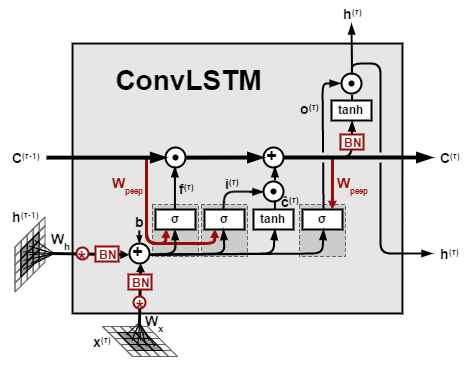

In [25]:
from IPython.display import Image
Image(filename='local/imgs/ConvLSTM.png', width=600)

[Image taken from here](https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7)


[ConvLSTMs](https://arxiv.org/pdf/1506.04214.pdf) are similar to a LSTMs, but the internal matrix multiplications are replaced by convolutions. The object that flows trough the cell is a 3D tensor instead of being just a 1D vector with features, like in ['peephole' LSTMs](https://www.jmlr.org/papers/volume3/gers02a/gers02a.pdf).

In [29]:
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization
frames = 20
model2 = Sequential()
model2.add(ConvLSTM2D(filters=5, kernel_size=(4, 4), 
                                 activation='relu', 
                                 padding='same', 
                                 input_shape=(frames,rows, columns, channels),return_sequences=True))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model2.add(ConvLSTM2D(filters=5, kernel_size=(8, 8), 
                                 activation='relu', 
                                padding='same', 
                                return_sequences=True))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model2.add(ConvLSTM2D(filters=5, kernel_size=(8, 8), 
                                 activation='relu', 
                                 padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())

model2.add(Dense(4, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model2.fit(Videos,y_trainOHE,epochs=80)

Epoch 1/80
3/3 [==============================] - 20s 4s/step - loss: 1.3864 - accuracy: 0.0797
Epoch 2/80
3/3 [==============================] - 1s 332ms/step - loss: 1.3855 - accuracy: 0.3148
Epoch 3/80
3/3 [==============================] - 1s 328ms/step - loss: 1.3829 - accuracy: 0.2500
Epoch 4/80
3/3 [==============================] - 1s 327ms/step - loss: 1.3702 - accuracy: 0.2539
Epoch 5/80
3/3 [==============================] - 1s 326ms/step - loss: 1.2301 - accuracy: 0.2766
Epoch 6/80
3/3 [==============================] - 1s 326ms/step - loss: 2.4703 - accuracy: 0.4383
Epoch 7/80
3/3 [==============================] - 1s 326ms/step - loss: 1.1096 - accuracy: 0.7578
Epoch 8/80
3/3 [==============================] - 1s 326ms/step - loss: 1.3064 - accuracy: 0.7156
Epoch 9/80
3/3 [==============================] - 1s 324ms/step - loss: 1.3381 - accuracy: 0.5000
Epoch 10/80
3/3 [==============================] - 1s 351ms/step - loss: 1.3508 - accuracy: 0.4961
Epoch 11/80
3/3 [====

In [31]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 20, 50, 130, 5)    1940      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 25, 65, 5)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 20, 25, 65, 5)     12820     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 20, 12, 32, 5)     0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 12, 32, 5)         12820     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 16, 5)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)              

In [28]:
y_est = np.argmax(model2.predict(VideosTest),axis=1)
print('accuracy testing = {}'.format(np.sum(y_est==Y)/80))

accuracy testing = 1.0
